In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import prange, njit
import time
from mpl_toolkits.mplot3d import Axes3D
from fireworks.ic import ic_tf as fic_tf 
from fireworks.ic import ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim
from tqdm.notebook import tqdm
from fireworks.particles import Particles_tf,Particles
import multiprocessing
from multiprocessing import Pool
import psutil


tf.config.optimizer.set_jit(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2024-05-27 22:23:36.156540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 22:23:36.156578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 22:23:36.157808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 22:23:36.164313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 22:23:36.813971: W tensorflow/compiler/tf2

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-27 22:23:38.204731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 22:23:38.245872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 22:23:38.246294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
def initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass):
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert np.min(particles.pos) >= min_pos and np.max(particles.pos) <= max_pos
    assert np.min(particles.vel) >= min_vel and np.max(particles.vel) <= max_vel
    assert np.min(particles.mass) >= min_mass and np.max(particles.mass) <= max_mass
    return particles

def initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass):
    particles = fic_tf.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert tf.reduce_min(particles.pos) >= min_pos and tf.reduce_max(particles.pos) <= max_pos
    assert tf.reduce_min(particles.vel) >= min_vel and tf.reduce_max(particles.vel) <= max_vel
    assert tf.reduce_min(particles.mass) >= min_mass and tf.reduce_max(particles.mass) <= max_mass
    return particles



In [3]:
# def measure_compile_time_and_memory(particles, facc_list):
#     compile_times = []
#     memory_usages = []
#     for facc in facc_list:
#         process = psutil.Process()
#         start_memory = process.memory_info().rss
#         t1 = time.perf_counter()
#         acceleration = facc(particles, softening=1e-10)
#         t2 = time.perf_counter()
#         end_memory = process.memory_info().rss
#         compile_times.append(t2 - t1)
#         memory_usages.append(end_memory - start_memory)
#     return compile_times, memory_usages
# def test_time_and_memory_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N"):
#         particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times, memory_usages = measure_compile_time_and_memory(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times, 'memory_usages': memory_usages}
#     return results

# def test_time_and_memory_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N_tf"):
#         particles = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times, memory_usages = measure_compile_time_and_memory(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times, 'memory_usages': memory_usages}
#     return results



In [4]:

def measure_compile_time_and_memory(particles, facc_list):
    compile_times = []
    cpu_memory_usages = []
    gpu_memory_usages = []
    
    for facc in facc_list:
        process = psutil.Process()
        start_cpu_memory = process.memory_info().rss
        t1 = time.perf_counter()
        acceleration = facc(particles, softening=1e-10)
        t2 = time.perf_counter()
        end_cpu_memory = process.memory_info().rss
        
        dt = t2 - t1
        compile_times.append(dt)
        d_cpu_mem = end_cpu_memory - start_cpu_memory
        cpu_memory_usages.append(d_cpu_mem)
        
        # Measure GPU memory usage
        gpu_memory_info = tf.config.experimental.get_memory_info('GPU:0')
        # gpu_memory_usages.append(gpu_memory_usage)
        gpu_memory_usages.append(gpu_memory_info['current'])
        
        print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds")
        print(f"CPU Memory usage: {d_cpu_mem / 1e6} MB")
        print(f"GPU Memory usage: {gpu_memory_info['current'] / 1e6} MB")
    
    return compile_times, cpu_memory_usages, gpu_memory_usages

def test_time_and_memory_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N"):
        particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles, facc_list)
        results[n_particles] = {
            'particles': particles,
            'compile_times': compile_times, 
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results

def test_time_and_memory_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N_tf"):
        particles = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles, facc_list)
        results[n_particles] = {
            'particles': particles,
            'compile_times': compile_times,
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results


In [5]:
# Defining initial conditions for the test
# N = np.logspace(1, 4, 15).astype(int)
N = np.linspace(10,12000,5).astype(int)
min_pos = 10.
max_pos = 100.
min_vel = 10.
max_vel = 100.
min_mass = 10.
max_mass = 100.
times_parallel=[]
times_sequential=[]


facc_list = [fdyn.acceleration_direct,
             fdyn.acceleration_direct_vectorized,
             fdyn.acceleration_pyfalcon
            ]
facc_list_tf = [fdyn.acceleration_tf]



output_results_tf = test_time_and_memory_ic_random_uniform_tf(
    N,
    min_pos,
    max_pos,
    min_vel,
    max_vel,
    min_mass,
    max_mass,
    facc_list_tf
)
output_results = test_time_and_memory_ic_random_uniform(
    N,
    min_pos,
    max_pos,
    min_vel,
    max_vel,
    min_mass,
    max_mass,
    facc_list
)

# Output Result
# output_results_tf = test_time_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list_tf) 
# output_results = test_time_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list)  # For non-TensorFlow 


 N_tf:   0%|          | 0/5 [00:00<?, ?it/s]

2024-05-27 22:23:42.051579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 22:23:42.052165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 22:23:42.052662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loaded 10 particles 

Time taken for acceleration using acceleration_tf: 0.359614633000092 seconds
CPU Memory usage: 59.0848 MB
GPU Memory usage: 0.003584 MB
Loaded 3007 particles 

Time taken for acceleration using acceleration_tf: 0.0021564529997704085 seconds
CPU Memory usage: 0.131072 MB
GPU Memory usage: 0.123648 MB
Loaded 6005 particles 

Time taken for acceleration using acceleration_tf: 0.0022911619998922106 seconds
CPU Memory usage: 0.0 MB
GPU Memory usage: 0.328192 MB
Loaded 9002 particles 

Time taken for acceleration using acceleration_tf: 0.0019033489988942165 seconds
CPU Memory usage: 0.0 MB
GPU Memory usage: 0.652032 MB
Loaded 12000 particles 

Time taken for acceleration using acceleration_tf: 0.0017717669998091878 seconds
CPU Memory usage: 0.131072 MB
GPU Memory usage: 1.024512 MB


 N:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded 10 particles 

Time taken for acceleration using acceleration_direct: 0.0008156820003932808 seconds
CPU Memory usage: 0.0 MB
GPU Memory usage: 0.880384 MB
Time taken for acceleration using acceleration_direct_vectorized: 0.0004611509993992513 seconds
CPU Memory usage: 0.131072 MB
GPU Memory usage: 0.880384 MB
Time taken for acceleration using acceleration_pyfalcon: 0.0001094960007321788 seconds
CPU Memory usage: 0.131072 MB
GPU Memory usage: 0.880384 MB
Loaded 3007 particles 

Time taken for acceleration using acceleration_direct: 71.48483549200137 seconds
CPU Memory usage: 0.0 MB
GPU Memory usage: 0.880384 MB
Time taken for acceleration using acceleration_direct_vectorized: 25.61194776299999 seconds
CPU Memory usage: 1.282048 MB
GPU Memory usage: 0.880384 MB
Time taken for acceleration using acceleration_pyfalcon: 0.0038935930006118724 seconds
CPU Memory usage: 0.393216 MB
GPU Memory usage: 0.880384 MB
Loaded 6005 particles 

Time taken for acceleration using acceleration_direc

In [13]:
output_results_tf[10]['gpu_memory_usages'][0]['current']

5632

# Parallelization

In [6]:
# Parallelization of same simulation computations
def parallel_acc(s_index, e_index):
    global pos
    global N_particles
    global mass

    # Calculate accelerations for particles within the specified index range
    dx = pos[s_index:e_index, 0, np.newaxis] - pos[:, 0]
    dy = pos[s_index:e_index, 1, np.newaxis] - pos[:, 1]
    dz = pos[s_index:e_index, 2, np.newaxis] - pos[:, 2]

    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r == 0] = 1

    dist = np.concatenate((dx, dy, dz)).reshape((3, e_index - s_index, N_particles))

    acc = - (dist / r**3 @ mass).T
    jerk = None
    pot = None

    return acc, jerk, pot

def acceleration_direct_vectorized():
    global pos
    global N_particles
    global mass

    # Calculate accelerations for all particles
    dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0]
    dy = pos[:, 1].reshape(N_particles, 1) - pos[:, 1]
    dz = pos[:, 2].reshape(N_particles, 1) - pos[:, 2]

    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r == 0] = 1

    dist = np.concatenate((dx, dy, dz)).reshape((3, N_particles, N_particles))

    acc = - (dist / r**3 @ mass).T
    jerk = None
    pot = None

    return acc, jerk, pot

def parallel_integrator(s_index, e_index):
    global pos
    global vel
    global tstep

    acc, _, _ = parallel_acc(s_index, e_index)

    vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep  # Velocity update
    pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep  # Position update

    return pos[s_index:e_index], vel[s_index:e_index]

def parallel_evo(N_particles, total_evo_time):
    global pos
    global vel

    # Count number of cores to determine the number of processes to start
    N_CORES = multiprocessing.cpu_count()
    N_PROCESSES = min(N_CORES, N_particles)
    pool = Pool(N_PROCESSES)

    positions = []
    process = psutil.Process()  # For memory usage tracking
    memory_usages = []

    for _ in tqdm(range(int(total_evo_time / tstep)), desc="Parallel Evolution"):
        start_memory = process.memory_info().rss

        if N_particles < N_CORES:
            future_results = pool.starmap_async(parallel_integrator, [(i, (i + 1)) for i in range(N_particles)])
        else:
            future_results = pool.starmap_async(parallel_integrator, [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES) for i in range(N_PROCESSES)])

        results = future_results.get()
        pos = np.concatenate([results[i][0] for i in range(len(results))])
        vel = np.concatenate([results[i][1] for i in range(len(results))])

        positions.append(pos)

        end_memory = process.memory_info().rss
        memory_usages.append(end_memory - start_memory)

    pool.close()

    return positions, memory_usages

# Running the simulation and collecting times and memory usages
times_parallel = []
memory_parallel = []

for n_particles in N:
    start = time.time()
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    pos = particles.pos
    vel = particles.vel
    mass = particles.mass
    N_particles = len(particles)
    tstep = 0.01

    # Run parallel simulations
    positions, memory_usages = parallel_evo(n_particles, total_evo_time=tstep)
    times_parallel.append(time.time() - start)
    memory_parallel.append(max(memory_usages) / 1e6)  # Convert bytes to MB
    start=time.time()
    # result_sequential = sequential_evo(n_particles,total_evo_time=tstep)
    # times_sequential.append(time.time()-start)
    
    





/home/draco/anaconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Parallel Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

Parallel Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

Parallel Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

Parallel Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

Parallel Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
output_results

{10: {'particles': Instance of the class Particles
  Number of particles: 10,
  'compile_times': [0.0008156820003932808,
   0.0004611509993992513,
   0.0001094960007321788],
  'cpu_memory_usages': [0, 131072, 131072],
  'gpu_memory_usages': [880384, 880384, 880384]},
 3007: {'particles': Instance of the class Particles
  Number of particles: 3007,
  'compile_times': [71.48483549200137,
   25.61194776299999,
   0.0038935930006118724],
  'cpu_memory_usages': [0, 1282048, 393216],
  'gpu_memory_usages': [880384, 880384, 880384]},
 6005: {'particles': Instance of the class Particles
  Number of particles: 6005,
  'compile_times': [285.62334923300114,
   102.52985049299969,
   0.007889210000939784],
  'cpu_memory_usages': [0, 651264, 786432],
  'gpu_memory_usages': [880384, 880384, 880384]},
 9002: {'particles': Instance of the class Particles
  Number of particles: 9002,
  'compile_times': [643.5115613830003,
   230.2887519270007,
   0.011954188999879989],
  'cpu_memory_usages': [0, 663552

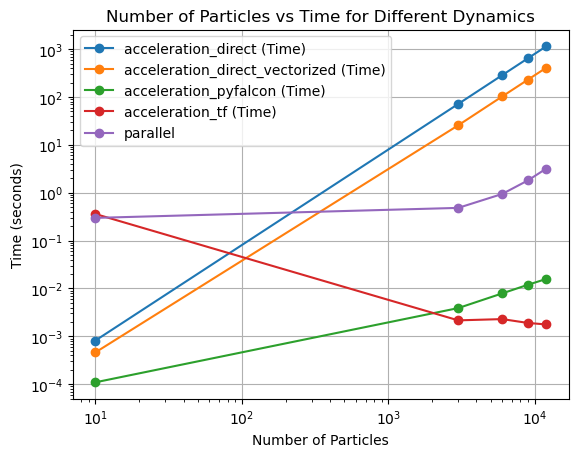

In [7]:
# Plotting non-TensorFlow time results
for facc, label in zip(facc_list,
                       ['acceleration_direct',
                        'acceleration_direct_vectorized',
                        'acceleration_pyfalcon'
                        ]):
    times = [output_results[n]['compile_times'][facc_list.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=f'{label} (Time)')

# Plotting TensorFlow time results
for facc, label in zip(facc_list_tf, ['acceleration_tf']):
    times = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=f'{label} (Time)')

plt.plot(N,times_parallel,label="parallel" ,marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.title('Number of Particles vs Time for Different Dynamics')
plt.legend()
plt.grid(True)
plt.show()

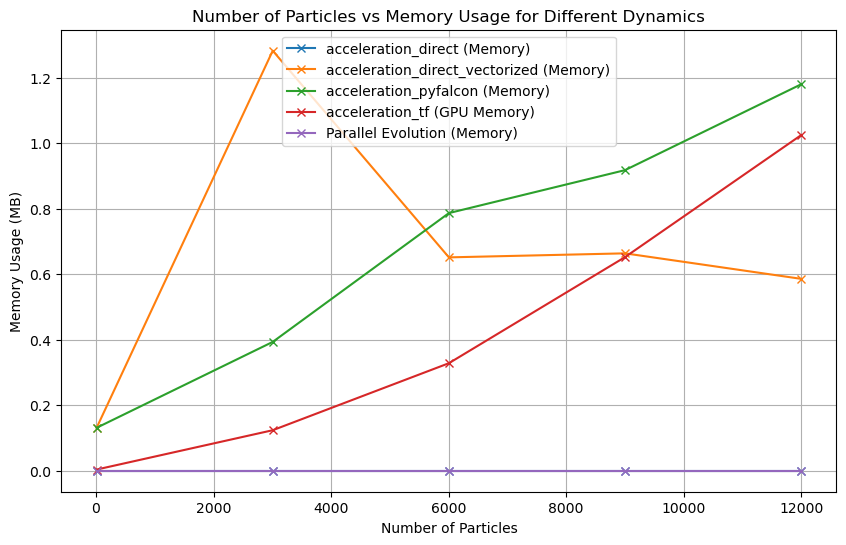

In [10]:
# Memory Usage Plot
plt.figure(figsize=(10, 6))

# Plotting non-TensorFlow memory results
for facc, label in zip(facc_list,
                       ['acceleration_direct',
                        'acceleration_direct_vectorized',
                        'acceleration_pyfalcon'
                        ]):
    memory = [output_results[n]['cpu_memory_usages'][facc_list.index(facc)] / 1e6 for n in N]  #  bytes to MB
    plt.plot(N, memory, marker='x', label=f'{label} (Memory)')

# Plotting TensorFlow memory results
for facc, label in zip(facc_list_tf, ['acceleration_tf']):
    memory = [output_results_tf[n]['gpu_memory_usages'][0] / 1e6 for n in N]  # Convert bytes to MB
    plt.plot(N, memory, marker='x', label=f'{label} (GPU Memory)')

plt.plot(N, memory_parallel, marker='x', label='Parallel Evolution (Memory)')
plt.xlabel('Number of Particles')
plt.ylabel('Memory Usage (MB)')
plt.title('Number of Particles vs Memory Usage for Different Dynamics')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# def measure_compile_time(particles, facc_list):
#     compile_times = []
#     for facc in facc_list:
#         t1 = time.perf_counter()
#         acceleration = facc(particles, softening=1e-10)
#         t2 = time.perf_counter()
#         dt = t2 - t1
#         print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds \n")
#         compile_times.append(dt)
#     return compile_times

# def test_time_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N"):
#         particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times = measure_compile_time(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times}
#     return results

# def test_time_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, facc_list):
#     results = {}
#     for n_particles in tqdm(N, desc=" N_tf"):
#         particles = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass)
#         compile_times = measure_compile_time(particles, facc_list)
#         results[n_particles] = {'particles': particles, 'compile_times': compile_times}
#     return results